<a href="https://colab.research.google.com/github/irham235/Projek-Machine-Learning/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Menyiapkan dataset

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

# upload kaggle.json
tarik = files.upload()

Saving kaggle (5).json to kaggle (5).json


In [3]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d 'gpiosenka/time-image-datasetclassification'

 99% 381M/383M [00:12<00:00, 26.2MB/s]
100% 383M/383M [00:12<00:00, 33.2MB/s]


In [6]:
import zipfile
dataset_zip = zipfile.ZipFile('time-image-datasetclassification.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

In [7]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
from tensorflow import keras

# ImageDataGenerator

In [15]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory("/content/train",
                                              class_mode='categorical',
                                              target_size=(150, 150),

                                              batch_size=10)
#test_datagen = ImageDataGenerator(
#    rescale=1.0/255,
#    validation_split=0.2
#)

test_generation = datagen.flow_from_directory("/content/test",
                                                   class_mode='categorical',
                                                   target_size=(150,150),
                                                   batch_size=10)

#validation_datagen = ImageDataGenerator(
#    rescale=1.0/255,
#)

#validation_generator = datagen.flow_from_directory("/content/valid",
#                                                              class_mode='categorical',
#                                                              target_size=(150,150),
#                                                              batch_size=10)

Found 11520 images belonging to 144 classes.
Found 1440 images belonging to 144 classes.


In [16]:
num_epochs = 10

# CNN Model

In [17]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(144, activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
      print('\nReached 92% accuracy.')
      self.model.stop_training = True
callback = MyCallback()

In [20]:
history = model.fit(
    train_generator,
    validation_data=test_generation,
    epochs=num_epochs,
    callbacks=[callback]
)

Epoch 1/10
   6/1152 [..............................] - ETA: 1:10 - loss: 50.3737 - accuracy: 0.0333

1152/1152 [==============================] - 84s 65ms/step - loss: 4.5652 - accuracy: 0.2080 - val_loss: 1.7141 - val_accuracy: 0.6021
Epoch 2/10
1152/1152 [==============================] - 74s 64ms/step - loss: 0.7411 - accuracy: 0.8043 - val_loss: 0.3871 - val_accuracy: 0.8958
Epoch 3/10
1152/1152 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9474
Reached 92% accuracy.
1152/1152 [==============================] - 74s 64ms/step - loss: 0.2146 - accuracy: 0.9474 - val_loss: 0.1956 - val_accuracy: 0.9472


# Plot

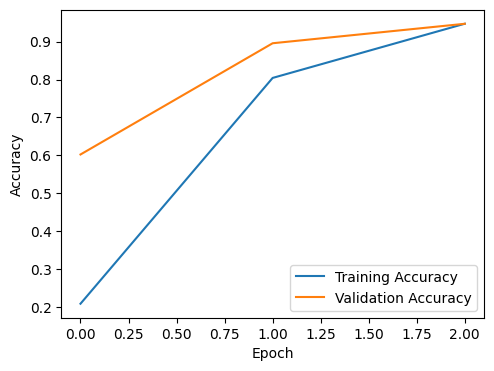

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

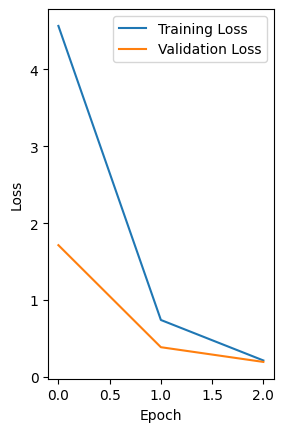

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# TF-Lite

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)